# Introduction to parallel computing (in Python)

::: fragment
If you want more, check out CS 475/575 Parallel Programming.
:::

## Approaching parallelism

- How do I do many things at once?
- How do I do one thing faster?

::: fragment
Computer: perform many simultaneous tasks
:::

::: fragment
Developer: determine dependencies between code and data
:::

## 

::: fragment
Up until now: serial thinking, like "x then y then z"
:::

::: fragment
Benefit of parallelism: problems execute faster—sometimes **much** faster.
:::

::: fragment
Downside to parallelism: harder to program, debug, open files, print to screen.
:::

## Why go parallel?

::: {.fragment .callout-important}
First: wait until your code works and you need it.
::: 

- The problem creates or requires too much data for a normal machine.
- The sun would explode before the computation would finish.
- The algorithm is easy to parallelize.
- The physics itself cannot be simulated at all with smaller resources.

# Scale and scalability

!["Scale and Scalability" book cover](./images/sense-and-sensibility.jpg)

## Scale and scalability

::: fragment
**Scale**: size of problem
::: 

::: fragment
Scale is proportional to number of processes $P$ used, and thus the maximum *degree of parallelism* possible.
::: 

::: fragment
**FLOPS**: number of floating-point operations per second
::: 

## Scaling up code

::: fragment
Scale up slowly—start with one processor, then 10, 100, etc.
::: 

::: fragment
**scalability**: how easy or hard it is to scale code
::: 

## Strong scaling

**strong scaling**: how runtime changes as a function of processor number for a fixed total problem size.

::: fragment
speedup $s$ ratio of time on one processor ($t_1$) to time on $P$ processors ($t_P$):

$$
s(P) = \frac{t_1}{t_P}
$$
:::

## Strong scaling

Efficient system: linear strong scaling speedup.

::: fragment
For example, [PyFR](http://www.pyfr.org/) computational fluid dynamics code:
:::

![Ref: P Vincent et al. "PyFR: Next-Generation High-Order Computational Fluid Dynamics on Many-Core Hardware." 22nd AIAA CFD Conference. 2015.](./images/pyfr-strongscaling.png){.r-stretch .fragment}

## Weak scaling

**weak scaling**: how runtime changes as a function of processor number for a fixed problem size per processor

::: fragment
sizeup $z$ for a problem size $N$:

$$
z(P) = \frac{t_1}{t_P} \times \frac{N_P}{N_1} 
$$
:::

## Weak scaling

Efficient system: linear sizeup. Or, constant time with additional processors/problem size. 

::: fragment
For example, [PyFR](http://www.pyfr.org/) computational fluid dynamics code:
:::

![Ref: P Vincent et al. "PyFR: Next-Generation High-Order Computational Fluid Dynamics on Many-Core Hardware." 22nd AIAA CFD Conference. 2015.](./images/pyfr-weakscaling.png){.r-stretch .fragment}

## Amdahl's Law

Some fraction of an algorithm, $α$, cannot be parallelized. 

::: fragment
Then, the maximum speedup/sizeup for $P$ processors is:

$$
\max( s(P) ) = \frac{1}{\alpha - \frac{1-\alpha}{P}} 
$$
::: 

::: fragment
The theoretically max speedup is:

$$
\max(s) = \frac{1}{\alpha}
$$
:::

## Types of problems

::: fragment
**embarassingly parallel**: algorithms with a high degree of independence and little communication between parts
::: 

::: fragment
Examples: summing large arrays, matrix multiplication, Monte Carlo simulations, some optimization approaches (e.g., stochastic and genetic algorithms)
::: 

::: fragment
Other algorithms have unavoidable bottlenecks: inverting a matrix, ODE integration, etc.
::: 

::: fragment
Not all hope is lost! Some parts may still benefit from parallelization.
::: 

# Example: N-body problem

::: fragment
Generalization of the classic two-body problem that governs the equations of motion for two masses. From Newton's law of gravity:

$$
\frac{dp}{dt} = G \frac{m_1 m_2}{r^2}
$$
:::

## Equations of motion

$$
\begin{align}
\mathbf{x}_{i,s} &= G \sum_{j=1, i \neq j} \frac{m_j (\mathbf{x}_{j,s-1} - \mathbf{x}_{i,s-1})}{||\mathbf{x}_{j,s-1} - \mathbf{x}_{i,s-1}||^3} \Delta t^2 + \mathbf{v}_{i,s-1} \Delta t + \mathbf{x}_{i,s-1} \\
\mathbf{v}_{i,s} &= G \sum_{j=1, i \neq j} \frac{m_j (\mathbf{x}_{j,s-1} - \mathbf{x}_{i,s-1})}{||\mathbf{x}_{j,s-1} - \mathbf{x}_{i,s-1}||^3} \Delta t + \mathbf{v}_{i,s-1}
\end{align}
$$

## No parallelism

In [3]:
import numpy as np

def remove_i(x, i):
    """Drops the ith element of an array."""
    shape = (x.shape[0]-1,) + x.shape[1:]
    y = np.empty(shape, dtype=float)
    y[:i] = x[:i]
    y[i:] = x[i+1:]
    return y

def a(i, x, G, m):
    """The acceleration of the ith mass."""
    x_i = x[i]
    x_j = remove_i(x, i) # don't compute on itself
    m_j = remove_i(m, i)
    diff = x_j - x_i
    mag3 = np.sum(diff**2, axis=1)**1.5
    # compute acceleration on ith mass
    result = G * np.sum(diff * (m_j / mag3)[:,np.newaxis], axis=0)
    return result

---

In [4]:
def timestep(x0, v0, G, m, dt):
    """Computes the next position and velocity for all masses given
    initial conditions and a time step size.
    """
    N = len(x0)
    x1 = np.empty(x0.shape, dtype=float)
    v1 = np.empty(v0.shape, dtype=float)
    for i in range(N): # update locations for all masses each step
        a_i0 = a(i, x0, G, m)
        v1[i] = a_i0 * dt + v0[i]
        x1[i] = a_i0 * dt**2 + v0[i] * dt + x0[i]
    return x1, v1

def initial_cond(N, D):
    """Generates initial conditions for N unity masses at rest
    starting at random positions in D-dimensional space.
    """
    x0 = np.random.rand(N, D) # use random initial locations
    v0 = np.zeros((N, D), dtype=float)
    m = np.ones(N, dtype=float)
    return x0, v0, m

---

Generating initial conditions and taking one timestep:

In [6]:
#| classes: fragment
#| output-location: fragment
x0, v0, m = initial_cond(10, 2)
x1, v1 = timestep(x0, v0, 1.0, m, 1.0e-3)

::: fragment
Driver function that simulates $S$ time steps:
:::

In [8]:
#| classes: fragment
def simulate(N, D, S, G, dt):
    x0, v0, m = initial_cond(N, D)
    for s in range(S):
        x1, v1 = timestep(x0, v0, G, m, dt)
        x0, v0 = x1, v1

## Measuring performance

In [9]:
#| classes: fragment
#| output-location: fragment
import time
Ns = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]
runtimes = []
for N in Ns:
    start = time.time()
    simulate(N, 3, 300, 1.0, 1e-3)
    stop = time.time()
    runtimes.append(stop - start)

---

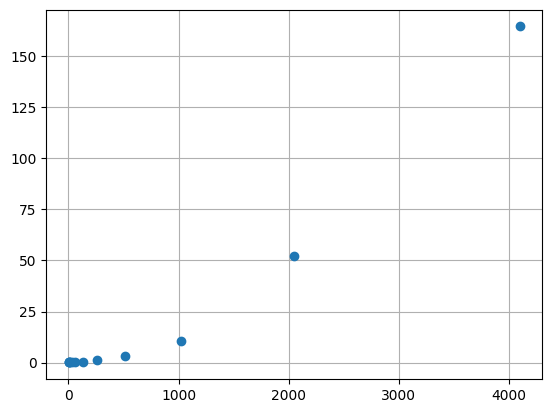

In [14]:
#| output-location: fragment
import matplotlib.pyplot as plt
plt.plot(Ns, runtimes, 'o')
plt.grid(True)
plt.show()

::: fragment
Does the problem scale quadratically?
:::

## Threads

- Threads perform work and are not blocked by work of other threads.
- Threads can communicate with each other through state


## Threads: probably don't use in Python.

- All threads execute in the same process as Python itself.
- Where to use? If you have high latency tasks where you can use spare time for another task (e.g., downloading a large file)


## N-body with threading